In [2]:
from sklearn import cluster
from nltk.corpus import stopwords
from re import sub
from tqdm import tqdm
from re import sub

import nltk
import pandas as pd
import numpy as np
import argparse

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer

import itertools

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize as tokenize
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
stemIgnStop = SnowballStemmer('english', ignore_stopwords=True)
lemmer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# doesn't want to work in the notebook for some reason, but works from the terminal so i'll just do this there
# import fuzzywuzzy
# from fuzzywuzzy import fuzz
# from fuzzywuzzy import process


[nltk_data] Downloading package wordnet to /home/mayla/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/mayla/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/mayla/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mayla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data = pd.read_pickle("beegframe.pickle")

In [4]:
data.columns

Index(['id', 'datetime', 'publisher', 'content', 'cleaned', 'fasttext',
       'bert'],
      dtype='object')

In [ ]:
#input list of noun phrases, list of unique elements (in descending order of avg. fuzz ratio), and dictionary
#replaces similar strings (reduces unique elements)
#adds replaced strings the dictionary with their replacements as an (old string, new string) tuple

def fuzzify(keys, featDict):
  done=[]
  for i in range(len(keys)):
    for x in range(i+1,len(keys)):
      if not(keys[x] in done):
        ratio=fuzz.ratio(keys[i],keys[x])
        if ratio>90:
          featDict[keys[x]]=keys[i]
          keys[x]=keys[i]
    done.append(keys[i])

In [35]:
#takes list of noun phrases, adds dictionary entries to keyDict with (noun phrase, avg. fuzz.ratio score)
#fuzz.ratio average is calculated using all non-identical elements
#returns a list of unique elements from the inputed list
#an equal number of tuples are added to keyDict as are in the returned list (every unique value is given a dictionary entry)

def simCount(features,keyDict):
  finList=[]
  for i in range(len(features)):
    if not(features[i] in finList): 
      count=0
      for x in range(len(features)):
        ratio=fuzz.ratio(features[i],features[x])
        if not(features[i] in keyDict):
          keyDict[features[i]]=0
        if not(ratio==100):
          keyDict[features[i]]=keyDict[features[i]]+ratio
          count=count+1
      finList.append(features[i])
      keyDict[features[i]]=keyDict[features[i]]/count

In [ ]:
#input a dictionary with (string, float) tuples
#returns a list of strings in descending order of their corresponding float

def sortKeys(keyDict):
  allVals=[keyDict.get(k) for k in keyDict]
  sortedVals=sorted(allVals,reverse=True)
  orderedFeat=[list(keyDict.keys())[list(keyDict.values()).index(x)] for x in sortedVals]
  return orderedFeat

In [4]:
tfidf = TfidfVectorizer().fit_transform(list(data["cleaned"]))

In [5]:
tfidf.shape

(63323, 31847)

In [31]:
# Create elbow graph 
def elbow_graph(embedding,n,name):
    wcss = []
    for i in range(1, n):
        inertia = cluster.KMeans(n_clusters=i).fit(embedding).inertia_
        wcss.append(inertia)

    plt.plot(range(1,n),wcss)
    plt.title('The Elbow Method Graph, '+name)
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.savefig('elbow')

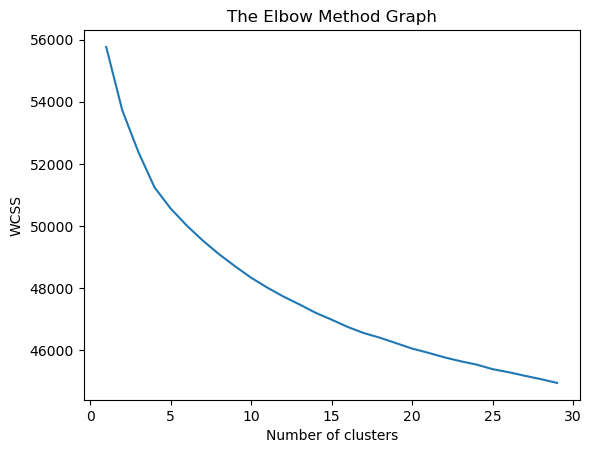

In [7]:
elbow_graph(list(data["bert"]),30, "Bert")

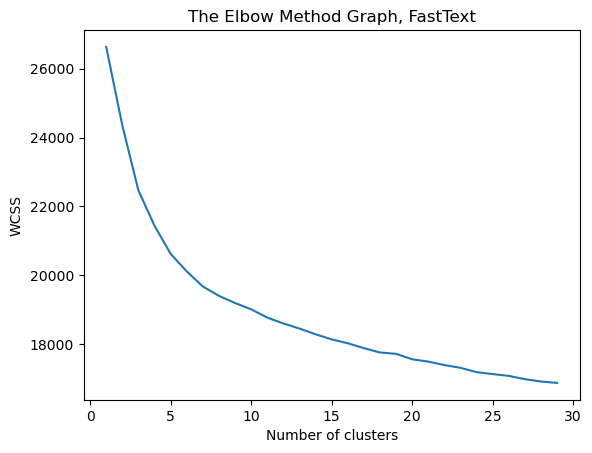

In [32]:
elbow_graph(list(data["fasttext"]),30,"FastText")

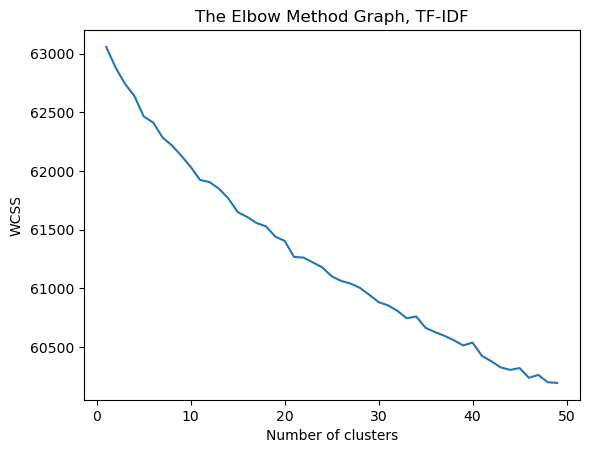

In [34]:
elbow_graph(tfidf,50,"TF-IDF")

In [9]:
data['kmeans.fasttext.7'] = cluster.KMeans(n_clusters=7).fit_predict(list(data['fasttext']))

In [10]:
data['kmeans.bert.11'] = cluster.KMeans(n_clusters=11).fit_predict(list(data['bert']))

In [10]:
data['fasttext'].shape

(63323,)

In [11]:
labels = cluster.AgglomerativeClustering(n_clusters = 10).fit_predict(list(data['fasttext'][0:10000]))

In [12]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 858, 1276, 3984,  575, 1407,  573,  317,  632,  292,   86]))

In [13]:
data['kmeans.bert.11'].value_counts()

5     8732
0     8123
8     7101
6     6148
4     5170
10    4886
9     4855
3     4827
7     4653
1     4432
2     4396
Name: kmeans.bert.11, dtype: int64

In [5]:
bert_pca_2 = PCA(n_components = 2).fit_transform(list(data['bert']))

In [6]:
fast_pca_2 = PCA(n_components = 2).fit_transform(list(data['fasttext']))

In [16]:
data['kmeans.bert.11'].value_counts()

5     8732
0     8123
8     7101
6     6148
4     5170
10    4886
9     4855
3     4827
7     4653
1     4432
2     4396
Name: kmeans.bert.11, dtype: int64

In [17]:
data['kmeans.fasttext.7'].value_counts()

3    19736
1    11068
0    10837
2     7815
4     6118
6     5546
5     2203
Name: kmeans.fasttext.7, dtype: int64

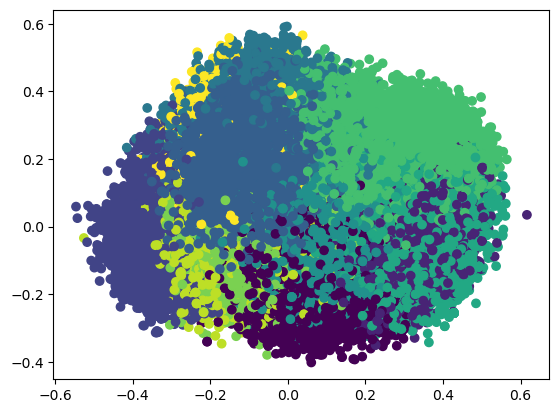

In [18]:
plt.scatter(bert_pca_2[:,0],bert_pca_2[:,1], c = list(data['kmeans.bert.11']))

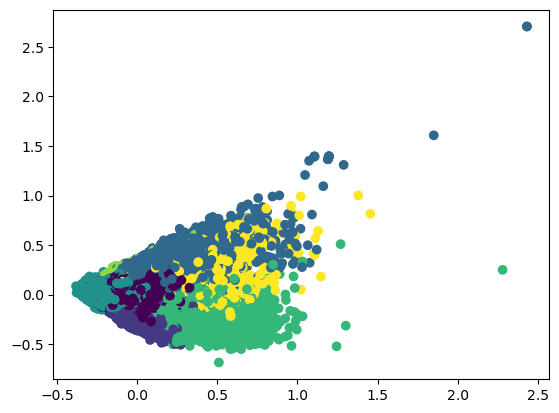

In [19]:
plt.scatter(fast_pca_2[:,0],fast_pca_2[:,1], c = list(data['kmeans.fasttext.7']))

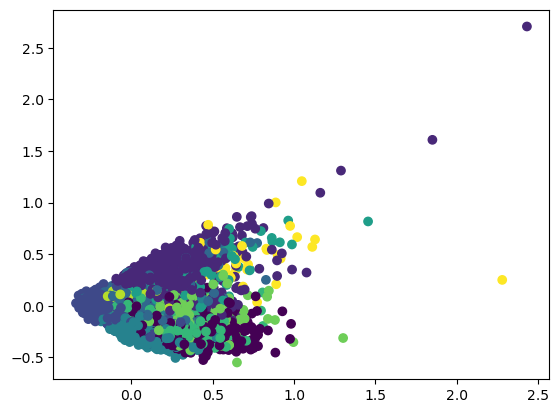

In [20]:
plt.scatter(fast_pca_2[0:10000,0],fast_pca_2[0:10000,1], c = labels)

In [21]:
np.argmax(fast_pca_2[:,1])

1186

In [22]:
data.shape

(63323, 9)

In [7]:
# counts the number of words in each cleaned entry
data["cleaned.len"] = data["cleaned"].apply(str.split, sep =  " ").apply(len)-1
# counts the number of words in each uncleaned entry
data["content.len"] = data["content"].apply(str.split, sep =  " ").apply(len)-1

In [11]:
bert_group = data.groupby(data["kmeans.bert.11"])
fast_group = data.groupby(data["kmeans.fasttext.7"])

In [25]:
bert_group["content.len"].mean()

kmeans.bert.11
0     10.201773
1     12.281137
2     10.468608
3     11.133416
4     16.058801
5      9.455795
6     12.055140
7     16.296368
8      9.095761
9      9.579403
10    11.407286
Name: content.len, dtype: float64

In [26]:
fast_group["cleaned.len"].mean()

kmeans.fasttext.7
0     9.043739
1     7.842519
2    13.054511
3     7.454297
4     9.197123
5     7.932365
6     9.061666
Name: cleaned.len, dtype: float64

In [27]:
data.loc[1:10000,"cleaned.len"].groupby(labels).mean()

0     9.480186
1    10.170846
2     9.063002
3     9.683478
4     9.015636
5     9.427574
6     9.239748
7     9.697785
8     9.119863
9    10.151163
Name: cleaned.len, dtype: float64

In [28]:
data.loc[1:10000,"cleaned.len"].mean()

9.3468

In [29]:
maxDate = data[data["kmeans.bert.11"]==1]["datetime"].dt.date.max()
print(maxDate)
data[data["kmeans.bert.11"]==4].sort_values(by=["datetime"], ascending = False)

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
print("whole data set:")
print("earliest date: ", data["datetime"].dt.date.min(), " latest date: ", data["datetime"].dt.date.max())

# doesn't seem to be a lot of variety here, but i don't know what it will look like plotted
print("bert clusters:")
for i in range(0,11):
    print("cluster ",i)
    print("size: ", len(data[data["kmeans.bert.11"]==i]))
    print("earliest date: ", data[data["kmeans.bert.11"]==i]["datetime"].dt.date.min(), " latest date: ", data[data["kmeans.bert.11"]==i]["datetime"].dt.date.max())
    print()

In [ ]:
color_dict = {0:'black', 1:'red', 2:'blue', 3:'green', 4:'pink', 5:'orange', 6:'purple'}
#[color_dict[i] for i in list(data["kmeans.fasttext.7"])]
color_list = ["pink","red","orange","yellow","green","blue","purple"]

color_list.extend(color_list*4)
print(color_list)

In [ ]:
viridis = plt.cm.get_cmap('viridis')
colors = list(viridis(np.random.rand(7)))
colors.extend(colors*4)

plt.figure().set_figwidth(10)
data.groupby(data["datetime"].dt.year)["kmeans.fasttext.7"].value_counts(sort = False).plot(kind='bar', rot=90, color = colors)

for i in range(4):
    plt.axvline(7*(i+1)-0.5, color='gray', linestyle='--')

In [ ]:
data["year"]=data["datetime"].dt.year

In [ ]:
viridis = plt.cm.get_cmap('viridis')
colors = list(viridis(np.random.rand(5)))
colors.extend(colors*6)

plt.figure().set_figwidth(10)
fast_group["year"].value_counts(sort = False).plot(kind='bar', rot=90, color = colors)

for i in range(6):
    plt.axvline(5*(i+1)-0.5, color='gray', linestyle='--')

In [ ]:
colors = list(viridis(np.random.rand(11)))
colors.extend(colors*4)

plt.figure().set_figwidth(15)
data.groupby(data["datetime"].dt.year)["kmeans.bert.11"].value_counts(sort= False).plot(kind='bar', rot=90, color = colors)

for i in range(4):
    plt.axvline(11*(i+1)-0.5, color='gray', linestyle='--')

In [ ]:
colors = list(viridis(np.random.rand(5)))
colors.extend(colors*10)

plt.figure().set_figwidth(15)
bert_group["year"].value_counts(sort= False).plot(kind='bar', rot=90, color = colors)

for i in range(10):
    plt.axvline(5*(i+1)-0.5, color='gray', linestyle='--')

In [ ]:
# not much here either
print("fasttext clusters:")
for i in range(0,7):
    print("cluster ",i)
    print("size: ", len(data[data["kmeans.fasttext.7"]==i]))
    print("earliest date: ", data[data["kmeans.fasttext.7"]==i]["datetime"].dt.date.min(), " latest date: ", data[data["kmeans.fasttext.7"]==i]["datetime"].dt.date.max())
    print()

In [12]:
pd.set_option("display.max_rows", 500)
# ordering of news sites changes dramatically between clusters
bert_group["publisher"].value_counts()

kmeans.bert.11  publisher       
0               nytimeshealth       1419
                nprhealth           1065
                NBChealth           1022
                bbchealth            842
                cnnhealth            723
                goodhealth           679
                latimeshealth        589
                cbchealth            581
                foxnewshealth        424
                everydayhealth       415
                KaiserHealthNews     409
                msnhealthnews        391
                reuters_health       181
                usnewshealth         111
                gdnhealthcare        105
                wsjhealth            101
1               goodhealth          1683
                everydayhealth       536
                latimeshealth        443
                cnnhealth            427
                nytimeshealth        371
                usnewshealth         201
                msnhealthnews        132
                NBChealt

In [13]:
fast_group["publisher"].value_counts()

kmeans.fasttext.7  publisher       
0                  wsjhealth           2171
                   goodhealth          1186
                   nytimeshealth        876
                   gdnhealthcare        729
                   cnnhealth            662
                   everydayhealth       633
                   latimeshealth        380
                   KaiserHealthNews     316
                   usnewshealth         296
                   cbchealth            225
                   reuters_health       177
                   NBChealth             52
                   bbchealth             48
                   nprhealth             42
                   foxnewshealth         15
1                  goodhealth          1956
                   everydayhealth       694
                   cnnhealth            459
                   cbchealth            304
                   latimeshealth        302
                   nytimeshealth        289
                   NBChealth            

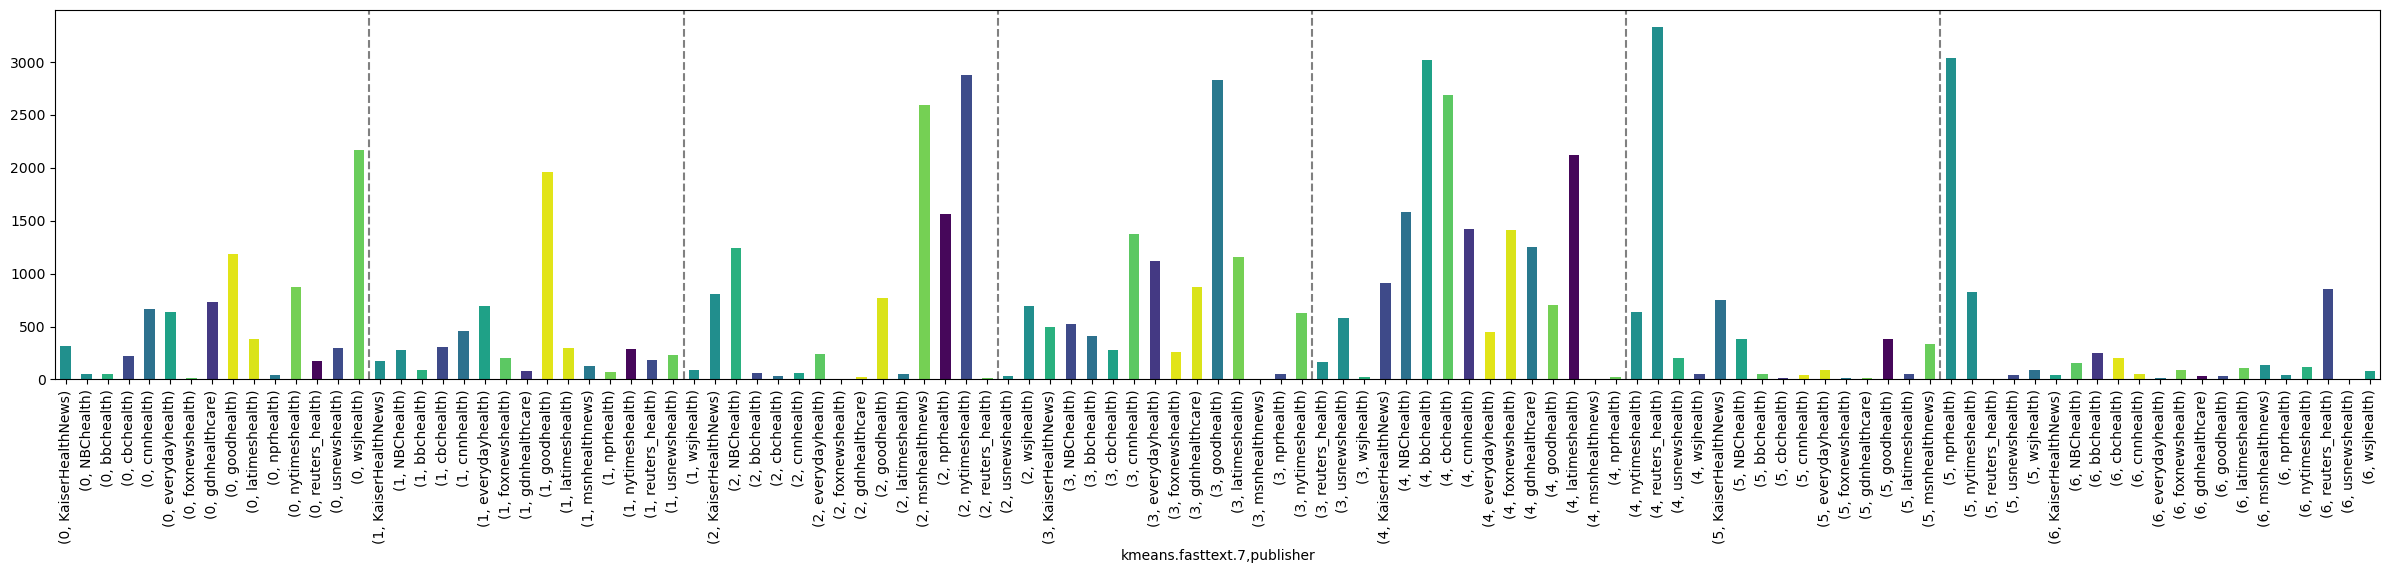

In [18]:
viridis = plt.cm.get_cmap('viridis')
colors = list(viridis(np.random.rand(15)))
colors.extend(colors*6)

plt.figure().set_figwidth(30)
fast_group["publisher"].value_counts(sort = False).plot(kind='bar', rot=90, color = colors)

for i in range(6):
    plt.axvline(15*(i+1)-0.5, color='gray', linestyle='--')

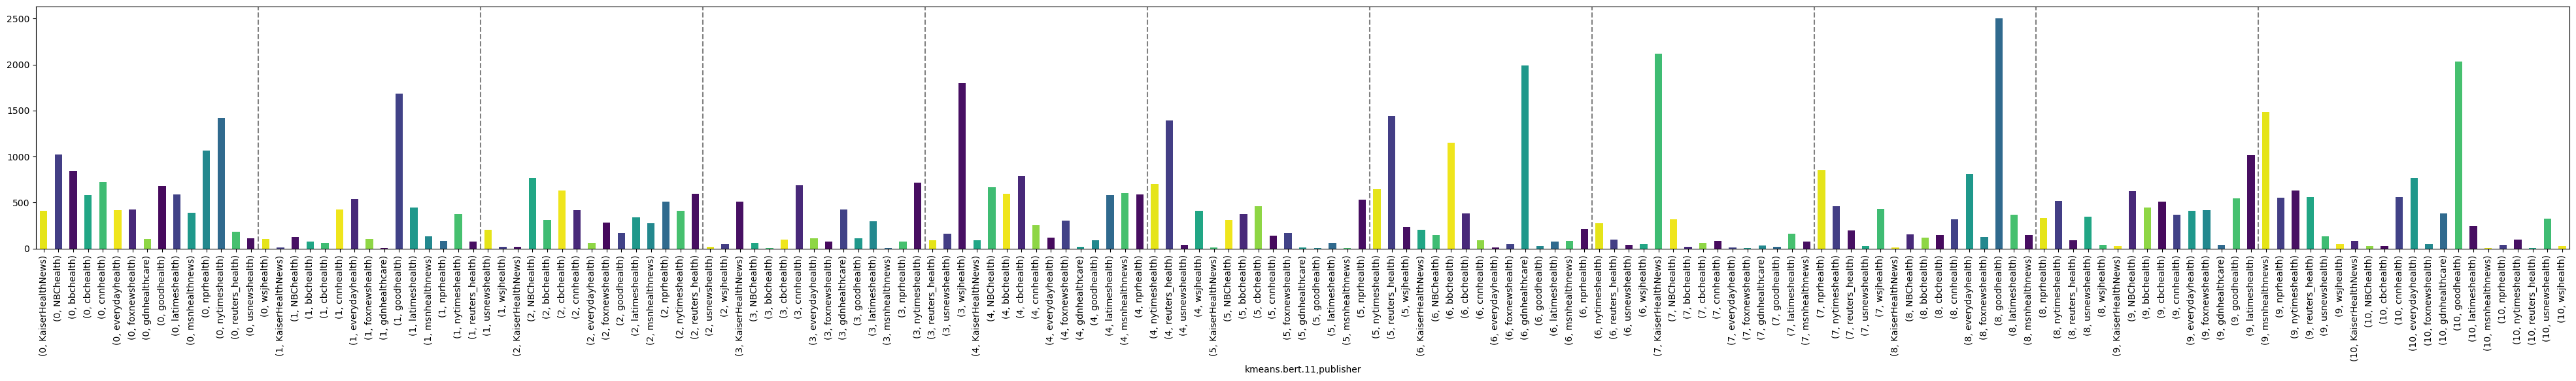

In [33]:
viridis = plt.cm.get_cmap('viridis')
colors = list(viridis(np.random.rand(15)))
colors.extend(colors*10)

plt.figure().set_figwidth(50)
bert_group["publisher"].value_counts(sort = False).plot(kind='bar', rot=90, color = colors)

for i in range(10):
    plt.axvline(15*(i+1)-0.5, color='gray', linestyle='--')

In [6]:
#lemmatizes words; optional to remove or leave stop words
def lem(tweets):
    for i in range(0,len(tweets)):
       tweets[i] = ' '.join([lemmer.lemmatize(w) for w in tokenize(tweets[i])])
    return tweets
    
#stems words; optional to remove or leave stop words
def stem(tweets):
    for i in range(0,len(tweets)):
       tweets[i] = ' '.join([stemmer.stem(w) for w in tokenize(tweets[i])])
    return tweets

In [8]:
text = np.unique(list(itertools.chain(*[data["cleaned"].iloc[j,].split(sep = " ") for j in range(data.shape[0]-1)])))

In [119]:
len(text)

43687

In [9]:
lemmed = lem(text)

In [10]:
lemmed[2500:2600,]

array(['Appetizers', 'Applause', 'Apple', 'AppleButtermilk',
       'AppleCranberry', 'AppleLive', 'AppleSpinach', 'Appleaday',
       'Applebees', 'Applegate', 'Apples', 'Appleshaped', 'Applicants',
       'Application', 'Applications', 'Applied', 'Apply', 'Applying',
       'Appoint', 'Appointment', 'Appointments', 'Appreciate', 'Approach',
       'Approaches', 'Appropriate', 'Approval', 'Approvals', 'Approve',
       'Approved', 'Approves', 'Approving', 'Apps', 'Appy', 'Apr',
       'Apricot', 'Apricots', 'April', 'AprilFoolsDay', 'Aprilbringing',
       'Apt', 'Aptalis', 'Aqua', 'AquaBounty', 'Aquarium', 'Aquatic',
       'Aquifers', 'Ara', 'Arab', 'Arabia', 'Arabian', 'Arabias',
       'Arachnophobia', 'Aranda', 'Arbitration', 'Arbys', 'Arcas',
       'Archaeologists', 'Archdiocese', 'Archer', 'Arches', 'Archon',
       'Arco', 'Arctic', 'Arcticdwelling', 'Ardelyx', 'Are', 'Area',
       'Areas', 'Arena', 'Arent', 'ArentÂ Kale', 'Are Small', 'Argentina',
       'Argentinas', 'Arge

In [124]:
len(np.unique(lemmed))

40944

In [125]:
stemmed = lem(text, remStop = False)
len(np.unique(stemmed))

40939

In [111]:
text[len(text)-1000:len(text),]

array(['violation', 'violations', 'violence', 'violencefree',
       'violenceplagued', 'violent', 'violets', 'violin', 'violinist',
       'viral', 'virgin', 'virginity', 'virtual', 'virtually', 'virtuous',
       'virulent', 'virus', 'viruses', 'virusfree', 'virusrelated',
       'viruss', 'visa', 'visas', 'visceral', 'visible', 'vision',
       'visionaries', 'visionary', 'visionthreatening', 'visit',
       'visited', 'visiting', 'visitor', 'visitors', 'visits', 'visor',
       'visual', 'visualizing', 'visually', 'visuals', 'vit', 'vital',
       'vitality', 'vitally', 'vitalsigns', 'vitamin', 'vitaminD',
       'vitaminEpacked', 'vitaminpacked', 'vitamins', 'vitaminsat',
       'vitaminsminerals', 'vitiligo', 'vitro', 'vivid', 'vi\x85',
       'vocal', 'vodka', 'voguing', 'voice', 'voiceAll', 'voices', 'void',
       'volatility', 'volleyba', 'volleyball', 'voltage', 'volts',
       'volume', 'voluntarily', 'voluntary', 'volunteer', 'volunteered',
       'volunteers', 'vomit', 'v

In [68]:
len(text)

43687

In [116]:
sample = '\x85 \xa0 Â Â10 Â10bn Â10m Â115bn Â140000 Â150000 Â15bn Â195m Â1bn Â1m Â20000 Â200K Â200m Â22 Â227K Â22bn Â22m Â250 Â250m Â25bn Â25m Â2bn Â2m Â300m Â30bn Â30m Â320000 Â32bn Â36000 Â388K Â3m Â40000  Â400K Â43bn Â47bn Â4m Â500m Â55 Â570m Â5bn Â5m Â640m Â65m Â6bn Â6m Â700 Â700m Â75m Â82m Â8bn Â8m Â900m Âs Â¼ Â½ Â½yearold ÂÂ Ãric ÃÂÃÂÃÂ ï ïawareness ð ð³ ðð ððð\x85'
print(sample)
sample = sub(r'[\d]','', sample)
sample = sub(r'[\x00-\x1f\x7f-\xffÂ¼½ïð³]', '', sample)
sample

   Â Â10 Â10bn Â10m Â115bn Â140000 Â150000 Â15bn Â195m Â1bn Â1m Â20000 Â200K Â200m Â22 Â227K Â22bn Â22m Â250 Â250m Â25bn Â25m Â2bn Â2m Â300m Â30bn Â30m Â320000 Â32bn Â36000 Â388K Â3m Â40000  Â400K Â43bn Â47bn Â4m Â500m Â55 Â570m Â5bn Â5m Â640m Â65m Â6bn Â6m Â700 Â700m Â75m Â82m Â8bn Â8m Â900m Âs Â¼ Â½ Â½yearold ÂÂ Ãric ÃÂÃÂÃÂ ï ïawareness ð ð³ ðð ððð


'    bn m bn   bn m bn m  K m  K bn m  m bn m bn m m bn m  bn  K m   K bn bn m m  m bn m m m bn m  m m m bn m m s   yearold  ric   awareness    '